# Project 2 (Ames Housing Data)

## Problem Statement
---

We are a property consultancy firm that aims to help residential home owners estimate the selling price of their homes. We thus aim to identify the features that are most important to predict sales price. This would allow us to provide our clients with an easy tool that gives quick estimates of how much their homes are worth, and help them identify aspects of their properties they can improve on to increase their selling price.

## Contents
---
- [Problem Statement](#Problem-Statement)
- [Data Cleaning](#Data-Cleaning)
- [Data Dictionary](#Data-Dictionary)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Modelling](#Modelling)
    - [Model 1 (All Variables)](#Model1)
    - [Model 2 (Drop Outliers)](#Model2)
    - [Model 3 (Log-transformation & Dropping 0-Coeffs)](#Model3)
- [Conclusions & Recommendations](#Conclusions-&-Recommendations)

## Loading data
---


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
import statsmodels.api as sm

%matplotlib inline

In [2]:
#Loading datasets
traindf = pd.read_csv("../datasets/train.csv")
testdf = pd.read_csv("../datasets/test.csv")

#Merge test and train datasets so that data cleaning and feature engineering steps will apply to both
#I'll split them again later!
df = pd.concat([traindf, testdf], axis=0)

wanted_cols = ["Id",
               "MS Zoning",
               "Lot Area", 
               "Neighborhood", 
               "Condition 1", 
               "Condition 2", 
               "House Style", 
               "Overall Qual", 
               "Overall Cond", 
               "Year Built", 
               "Year Remod/Add", 
               "Bsmt Qual",
               "Bsmt Unf SF",
               "Bsmt Full Bath", 
               "Bsmt Half Bath", 
               "Full Bath", 
               "Half Bath", 
               "Bedroom AbvGr", 
               "Kitchen AbvGr", 
               "Fireplaces", 
               "Garage Finish", 
               "Wood Deck SF", 
               "Open Porch SF", 
               "Enclosed Porch", 
               "3Ssn Porch", 
               "Screen Porch", 
               "Pool QC", 
               "Fence", 
               "Yr Sold",
               "SalePrice"]

#Subsetting dataset with only wanted columns
df = df[wanted_cols]

## Data Cleaning
---
#### Excluding data from analysis:
- As we are analyzing residential properties specifically, I excluded non-residential properties, which only amounted to 123 data points in total.
- I've decided to exclude split level, split foyer, and properties with unfinished floors as there are only 170 data points in total. This will also enable me to transform the variable into "number of floors" instead.

In [3]:
#Dropping data for non-residential properties
df.drop(df.index[(df["MS Zoning"] != "RH") & 
                 (df["MS Zoning"] != "RL") & 
                 (df["MS Zoning"] != "RM")], inplace = True)

#Dropping data for split level, split foyer, and properties with unfinished floors
df.drop(df.index[(df["House Style"] != "1.5Fin") & 
                 (df["House Style"] != "2.5Fin") &
                 (df["House Style"] != "1Story") &
                 (df["House Style"] != "2Story")], inplace = True)

#### Check missing values
- Missing values for Pool QC, Fence, Garage Type, Bsmt Qual, etc. are because the property does not have a pool/fence/garage/basement. 
- Rows with missing values for SalePrice are from the test dataset.
- Two null values for the number of basement bathrooms and unfinished sqft should be 0 instead.

In [4]:
# Check for missing values
df.isnull().sum().sort_values(ascending = False).head(10)

Pool QC           2288
Fence             1851
SalePrice          640
Garage Finish      118
Bsmt Qual           68
Bsmt Half Bath       2
Bsmt Full Bath       2
Bsmt Unf SF          1
Fireplaces           0
Open Porch SF        0
dtype: int64

In [5]:
#Changing null values for number of basement bathrooms and unfinished sqft to 0
df["Bsmt Full Bath"] = df["Bsmt Full Bath"].replace(np.nan, 0)
df["Bsmt Half Bath"] = df["Bsmt Half Bath"].replace(np.nan, 0)
df["Bsmt Unf SF"] = df["Bsmt Unf SF"].replace(np.nan, 0)

#### Feature Engineering:
- Turn "House Style" into **number of floors** as a float 
- Add up total **number of full bathrooms and half bathrooms** (include above grade and basement)
- Create **property age** by subtracting year built from year sold
- From "Bsmt Qual", "Garage Type", "Pool QC", "Fence", and the 5 variables relating to size of the porch in square feet, create binary dummy variables for **whether the house has a basement, a garage, a pool, a porch, and a fence**
- From "Condition 1" and "Condition 2", create binary dummy variables for **whether the house is near to some feature** i.e. a major road, a railway station, or some other positive feature
- Create dummy variable for **whether the house has ever been remodeled**
- I need to dummy code the neighborhood variable, but I'll leave that for after I've renamed and reordered the columns

In [6]:
#Turn "House Style" to number of floors as a float
def convert_to_floors(cell):
    if cell == "1Story":
        return 1
    elif cell == "1.5Fin" or cell == "1.5Unf":
        return 1.5
    elif cell == "2Story":
        return 2
    elif cell == "2.5Fin" or cell == "2.5Unf":
        return 2.5
    else:
        return np.nan

df["num_floors"] = df["House Style"].apply(convert_to_floors)

In [7]:
#Add up number of full bathrooms and half bathrooms
df["num_full_baths"] = df["Full Bath"] + df["Bsmt Full Bath"]
df["num_half_baths"] = df["Half Bath"] + df["Bsmt Half Bath"]

In [8]:
#Create variable for age of property
df["property_age"] = df["Yr Sold"] - df["Year Built"]

In [9]:
#Create dummy variables for whether the house has a basement, garage, pool or a fence
#For these variables, null values indicate that the house does not have a specific feature
def null_dummy(cell):
    if str(cell) == "nan":
        return 0
    else:
        return 1

df["has_bsmt"] = df["Bsmt Qual"].apply(null_dummy)
df["has_garage"] = df["Garage Finish"].apply(null_dummy)
df["has_pool"] = df["Pool QC"].apply(null_dummy)
df["has_fence"] = df["Fence"].apply(null_dummy)

#Create dummy variables for whether the house has a porch
#These variables are in sq.ft so across all 5 porch variables indicates a lack of a porch

def zero_dummy(cell):
    if cell != 0:
        return 1
    else:
        return 0

df["has_porch"] = (df["Wood Deck SF"] +
                   df["Open Porch SF"] + 
                   df["Enclosed Porch"] +
                   df["3Ssn Porch"] +
                   df["Screen Porch"]).apply(zero_dummy)

In [10]:
#Create dummy variable for whether the house has an unfinished basement
df["has_unf_bsmt"] = df["Bsmt Unf SF"].apply(zero_dummy)

#Create dummy variable for whether the house has an unfinished garage
def unf_garage(cell):
    if str(cell) == "Unf":
        return 1
    else:
        return 0

df["has_unf_garage"] = df["Garage Finish"].apply(unf_garage)

In [11]:
#Create dummy variable for whether the house is near a major road
df["near_road1"] = df["Condition 1"].map(lambda cell: 1 if (cell == "Artery")|(cell == "Feedr") else 0)
df["near_road2"] = df["Condition 2"].map(lambda cell: 1 if (cell == "Artery")|(cell == "Feedr") else 0)
df["near_road"] = (df["near_road1"] + df["near_road2"]).apply(zero_dummy)

#Create dummy variable for whether the house is near a railway station
rail_var = ["RRAe", "RRAn","RRNe", "RRNn"]
df["near_rail1"] = df["Condition 1"].map(lambda cell: 1 if (cell in rail_var) else 0)
df["near_rail2"] = df["Condition 2"].map(lambda cell: 1 if (cell in rail_var) else 0)
df["near_rail"] = (df["near_rail1"] + df["near_rail2"]).apply(zero_dummy)

#Create dummy variable for whether the house is near some other positive feature
df["near_pos1"] = df["Condition 1"].map(lambda cell: 1 if (cell == "PosA")|(cell == "PosN") else 0)
df["near_pos2"] = df["Condition 2"].map(lambda cell: 1 if (cell == "PosA")|(cell == "PosN") else 0)
df["near_pos"] = (df["near_pos1"] + df["near_pos2"]).apply(zero_dummy)

In [12]:
#Create dummy variable for whether the house has ever been remodeled
df["has_remodeled"] = (df["Year Remod/Add"] - df["Year Built"]).apply(zero_dummy)

#### Renaming and reordering columns

In [13]:
#Drop columns that were used for transforming new columns and are no longer needed
cols_to_drop = ["MS Zoning", 
                "Condition 1",
                "Condition 2", 
                "near_road1", 
                "near_road2", 
                "near_rail1", 
                "near_rail2", 
                "near_pos1", 
                "near_pos2",
                "House Style",
                "Year Built",
                "Year Remod/Add",
                "Bsmt Qual",
                "Bsmt Unf SF",
                "Bsmt Full Bath",
                "Bsmt Half Bath",
                "Full Bath",
                "Half Bath",
                "Garage Finish", 
                "Wood Deck SF",
                "Open Porch SF",
                "Enclosed Porch",
                "3Ssn Porch", 
                "Screen Porch",
                "Pool QC",
                "Fence",
                "Yr Sold"]

df.drop(cols_to_drop, axis = 1, inplace = True)

In [14]:
#Renaming columns
rename_cols = {"Lot Area": "property_size", 
               "Neighborhood": "neighborhood", 
               "Overall Qual": "overall_qual", 
               "Overall Cond": "overall_cond", 
               "Bedroom AbvGr": "num_bedrooms", 
               "Kitchen AbvGr": "num_kitchens",
               "Fireplaces": "num_fireplaces", 
               "SalePrice": "sale_price"}

df.rename(columns = rename_cols, inplace= True)

In [15]:
#Reordering columns
reordered_cols = ["Id",
                  "sale_price",
                  "property_size",
                  "overall_qual",
                  "overall_cond",
                  "property_age",  
                  "num_floors",
                  "num_bedrooms", 
                  "num_full_baths", 
                  "num_half_baths", 
                  "num_kitchens", 
                  "num_fireplaces",
                  "has_remodeled",
                  "has_bsmt",
                  "has_unf_bsmt",
                  "has_garage",
                  "has_unf_garage",
                  "has_porch", 
                  "has_fence",
                  "has_pool",
                  "near_road",
                  "near_rail",
                  "near_pos",
                  "neighborhood"]

df = df[reordered_cols]

#### Dummy coding neighborhood
I'm dummy coding the neighborhood variable only after renaming and reordering the columns so that I don't have to type out the names of all the dummy variables when reordering the columns.

In [16]:
df = pd.get_dummies(df, columns = ["neighborhood"], prefix = "area")

#### Splitting the datasets
I combined the test and train datasets so that the feature engineering steps would apply to the test dataset as well. I am now splitting them back into train and test datasets.

In [17]:
traindf = df[df["sale_price"].notnull()]
testdf = df[df["sale_price"].isnull()]

#### Checking types and min / max values

In [18]:
#Data types look fine!
#There are no missing values either (missing sale price are rows from the test dataset)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2296 entries, 0 to 876
Data columns (total 51 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              2296 non-null   int64  
 1   sale_price      1656 non-null   float64
 2   property_size   2296 non-null   int64  
 3   overall_qual    2296 non-null   int64  
 4   overall_cond    2296 non-null   int64  
 5   property_age    2296 non-null   int64  
 6   num_floors      2296 non-null   float64
 7   num_bedrooms    2296 non-null   int64  
 8   num_full_baths  2296 non-null   float64
 9   num_half_baths  2296 non-null   float64
 10  num_kitchens    2296 non-null   int64  
 11  num_fireplaces  2296 non-null   int64  
 12  has_remodeled   2296 non-null   int64  
 13  has_bsmt        2296 non-null   int64  
 14  has_unf_bsmt    2296 non-null   int64  
 15  has_garage      2296 non-null   int64  
 16  has_unf_garage  2296 non-null   int64  
 17  has_porch       2296 non-null   in

In [19]:
#Checking min/max values -- there's a negative property age?
pd.DataFrame({"min": df.min(), "max": df.max()})

,min,max
Id,1.0,2929.0
sale_price,12789.0,611657.0
property_size,1300.0,215245.0
overall_qual,1.0,10.0
overall_cond,1.0,9.0
property_age,-1.0,136.0
num_floors,1.0,2.5
num_bedrooms,0.0,8.0
num_full_baths,0.0,6.0
num_half_baths,0.0,4.0


In [20]:
#There's only one row with a negative property age
df.loc[df["property_age"]<0]

,Id,sale_price,property_size,overall_qual,overall_cond,property_age,num_floors,num_bedrooms,num_full_baths,num_half_baths,...,area_NoRidge,area_NridgHt,area_OldTown,area_SWISU,area_Sawyer,area_SawyerW,area_Somerst,area_StoneBr,area_Timber,area_Veenker
1885,2181,183850.0,39290,10,5,-1,1.0,2,3.0,2.0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
#Dropping row with negative property age
df.drop(df.index[df["property_age"]<0], inplace = True)

#### Checking for outliers

In [22]:
def plus3sd(variable):
    return df[variable].mean() + (3*df[variable].std())

def minus3sd(variable):
    return df[variable].mean() - (3*df[variable].std())

There are 21 properties above mean + 3sd.
There are 0 properties below mean - 3sd.


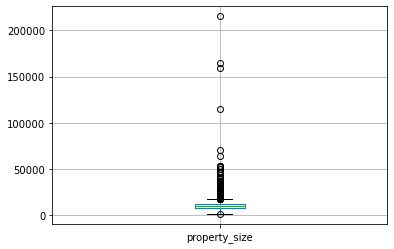

In [23]:
#checking for outliers for property size
df.boxplot("property_size");

print("There are", len(df[df["property_size"]>plus3sd("property_size")]), "properties above mean + 3sd.")
print("There are", len(df[df["property_size"]<minus3sd("property_size")]), "properties below mean - 3sd.")

As the boxplot seems to indicate a number of clear outliers, I will drop the 21 properties that have sizes more than 3SD away from the mean size.

In [24]:
#dropping 21 outliers
df.drop(df.index[df["property_size"]>plus3sd("property_size")], inplace = True)

There are 5 properties above mean + 3sd.
There are 0 properties below mean - 3sd.


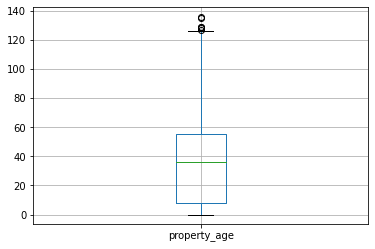

In [25]:
#checking for outliers for property age
df.boxplot("property_age");

print("There are", len(df[df["property_age"]>plus3sd("property_age")]), "properties above mean + 3sd.")
print("There are", len(df[df["property_age"]<minus3sd("property_age")]), "properties below mean - 3sd.")

As there are only a small number of outliers, I will drop the 5 outliers that are more than 3SD away from the mean.

In [26]:
#dropping 4 outliers
df.drop(df.index[df["property_age"]>plus3sd("property_age")], inplace = True)

There are 29 properties above mean + 3sd.
There are 0 properties below mean - 3sd.


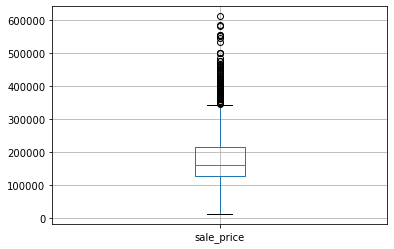

In [27]:
#checking for outliers for sale price
df.boxplot("sale_price");
print("There are", len(df[df["sale_price"]>plus3sd("sale_price")]), "properties above mean + 3sd.")
print("There are", len(df[df["sale_price"]<minus3sd("sale_price")]), "properties below mean - 3sd.")

There are a large number of outliers, but they seem to indicate a trailing tail. As such, I will not remove the 29 datapoints that are more than 3SD away from the mean.

## Data Dictionary
---
I chose to narrow down to a small number of variables and to simplify many of the variables in the original dataset to whether the house has a certain feature or not (e.g. whether it has a basement). The reason for this is because our aim is to provide clients with an easy tool that can give them quick estimates of how much their house is worth. As such, a key factor that influenced the selection of variables was whether it would be easy and quick for clients to fill in the fields needed to generate a prediction. The following features were thus chosen for the model:

|Feature|Description|
|---|---|
|**sale_price**|The price at which the house was sold.|
|**property_size**|The size of the house in square feet.|
|**overall_qual**|The quality of the material and finish of the house.|
|**overall_cond**|The condition of the house at the time it was sold.|
|**property_age**|The number of years since the house was first built at the time it was sold.|
|**num_floors**|The number of floors in the house.|
|**num_bedrooms**|The number of bedrooms in the house, not including basement bedrooms.|
|**num_full_baths**|The number of full bathrooms in the house, including those in the basement. Full bathrooms are bathrooms that contain a sink, a toilet, a shower, and a bathtub.|
|**num_half_baths**|The number of half bathrooms in the house, including those in the basement. Half bathrooms are bathrooms that contain a sink and toilet, but no bathing facilities.|
|**num_kitchens**|The number of kitchens in the house.|
|**num_fireplaces**|The number of fireplaces in the house.|
|**has_remodeled**|Binary variable representing whether the house has ever been remodeled.|
|**has_bsmt**|Binary variable representing whether the house has a finished basement.|
|**has_unf_bsmt**|Binary variable representing whether the house has an unfinished basement.|
|**has_garage**|Binary variable representing whether the house has a finished garage.|
|**has_unf_garage**|Binary variable representing whether the house has an unfinished garage.|
|**has_porch**|Binary variable representing whether the house has a porch or deck.|
|**has_fence**|Binary variable representing whether the house has a fence.|
|**has_pool**|Binary variable representing whether the house has a pool.|
|**near_road**|Binary variable representing whether the house is adjacent to or within 200' of an arterial or feeder road|
|**near_rail**|Binary variable representing whether the house is adjacent to or within 200' of a railway station.|
|**near_pos**|Binary variable representing whether the house is near a positive feature such as a park or greenbelt.|
|**area_(name)**|Dummy variables representing the neighborhood in which the house is located in.|

## Exploratory Data Analysis
---
#### Distribution of variables
From the histograms, we can see that sale price and property size have skewed distributions with long tails to the right. Property age was distributed with most properties being relatively new at time of sale. There seems to be a good variance for most of the variables.

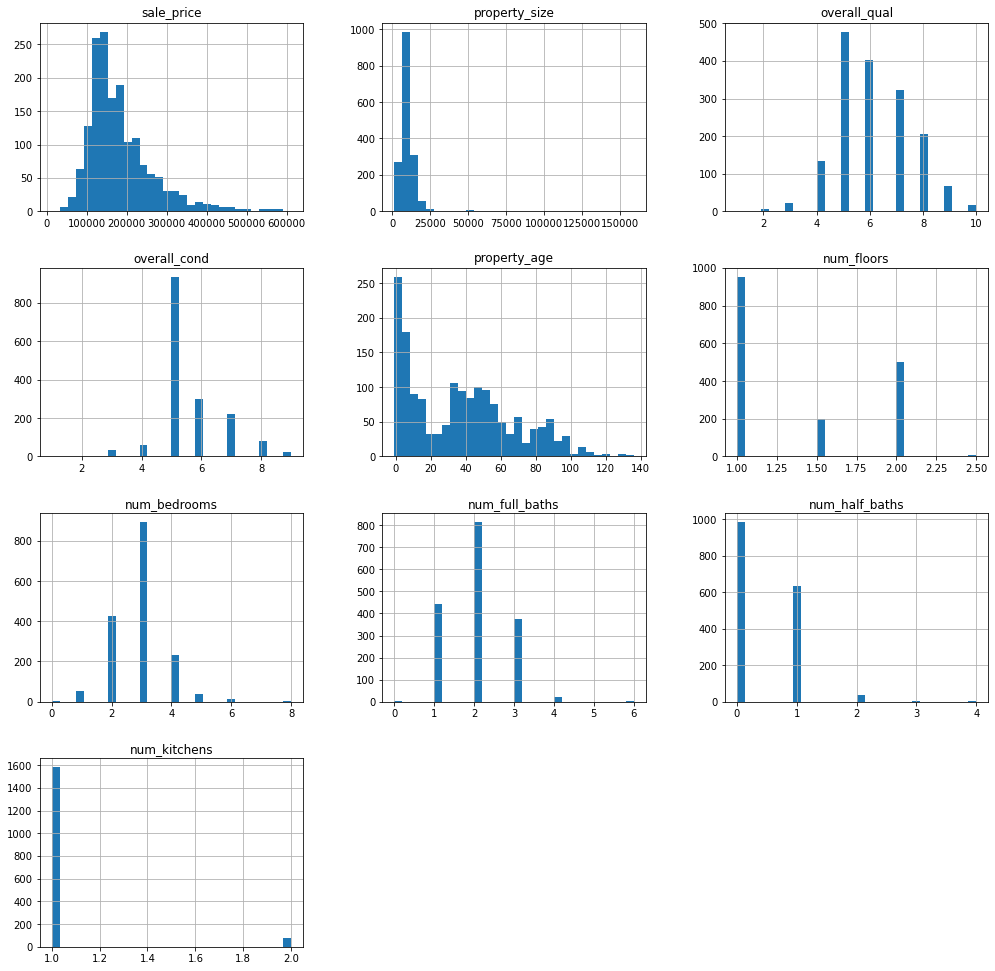

In [28]:
traindf.iloc[:,1:11].hist(bins=30, figsize=(17, 17));

#### Correlation of variables
From the correlation matrix, we can see that a number of variables were strongly correlated with sales price:
- Overall quality was most strongly correlated with sales price, indicating that houses built with better quality materials and finishing sold better.
- Older properties were negative correlated with sales price, which could be explained by it's negative correlation with overall quality as well. Older houses seemed to deteriorate in quality.
- Other factors that were associated with higher sales price included positive utilities such as more bathrooms, fireplaces, garages, and porches.

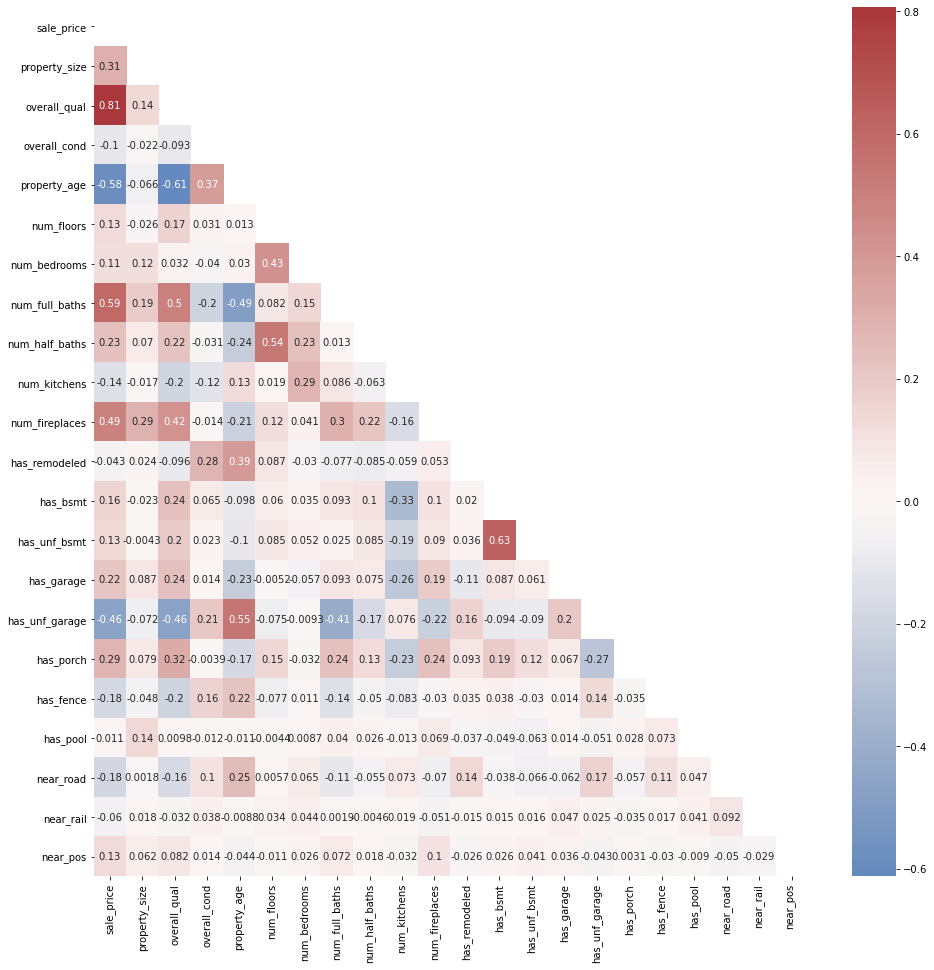

In [29]:
corrs = traindf.iloc[:,1:23].corr()
mask = np.triu(np.ones_like(corrs, dtype=bool))
plt.figure(figsize=(16,16))
sns.heatmap(corrs, annot = True, cmap = "vlag", center = 0, mask = mask);

Independent variables are mostly uncorrelated with one another saved for a few pairs which had correlation coefficients above 0.5. For three pairs, the variables were not conveying the same thing and so were not redundant. I thus decided not to drop them. These pairs are:
- **Having an unfinished basement was strongly correlated (corr: 0.61) with having a basement.** This indicates that a large proportion of houses with basements have unfinished basements. However, the reason why I included these variables is because I wanted to be able to tell clients if finishing an unfinished basement would significantly affect their selling price. I thus decided to keep both variables.
- **Newer properties were more likely to have garages (corr: 0.56).** However, as the variables are conveying different things, neither of them are redundant. As such, none of the two variables were dropped from this pair.
- **Houses that have more floors have more half bathrooms (corr: 0.55).** This is likely because the house has more space. Again, because the variables were conveying different things, neither of them were redundant and thus were not dropped from the model.

One pair seemed to warrant more inspection:

- **Property age and overall quality conveyed a strong correlation (corr: 0.62).** This is likely because older houses are likely to deteriorate in overall quality over time. Overall quality was also associated with positive utilities such as the number of full bathrooms (corr: 0.5) and fireplaces (corr: 0.42), and the presence of a garage (corr: 0.47) or porch (0.32). This is likely because these positive features factor into the overall evaluation of the property's quality.

Because of this, I considered that overall quality may be a redundant feature that should be dropped to reduce multicollinearity. However, because overall quality is very strongly related to sales price, this reduced the predictive capacity of the model significantly. This is likely because other factors such as the material used to build the house, and how well the house is maintained over time factors into overall quality as well, but is not captured by other variables in the model. As such, I ultimately decided to leave both property age and overall quality in the model despite a high correlation.

#### Descriptive statistics
From the descriptive statistics below, we can see that:
- 47% of homes in the dataset have remodelled their house at some point
- 97% have basements, and the vast majority are unfinished basements
- 94% have garages, but only half of them are unfinished garages
- 83% have some kind of porch or deck
- Only 19% have fences
- An extremely small percent have pools (0.03%)
- 9% are near major roads, 3% are near a railway station, and 2% are near a park or some other positive feature

In [30]:
df.iloc[:,12:23].describe()

,has_remodeled,has_bsmt,has_unf_bsmt,has_garage,has_unf_garage,has_porch,has_fence,has_pool,near_road,near_rail,near_pos
count,2255.000000,2255.000000,2255.000000,2255.000000,2255.000000,2255.000000,2255.000000,2255.000000,2255.000000,2255.000000,2255.000000
mean,0.470953,0.971175,0.928603,0.948559,0.423060,0.826608,0.196452,0.002661,0.092683,0.036807,0.022173
std,0.499266,0.167351,0.257544,0.220945,0.494154,0.378670,0.397403,0.051525,0.290052,0.188330,0.147278
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The neighborhoods that had the highest selling prices were Northridge Heights, Northridge, and Stone Brook, while the neighborhoods with the lowest selling prices were Meadow Village, Briardale, and Iowa DOT and Rail Road.

The dataset was mostly comprised of houses from North Ames, College Creek, and Old Town. Neighborhoods like Landmark, Greenhill, and Greens were underrepresented.

In [31]:
ave_price_by_area = [round(df["sale_price"].loc[df[area]==1].mean()) for area in df.iloc[:,22:]]
pd.DataFrame({"Ave. price": ave_price_by_area,
              "No. of homes": df.iloc[:,22:].sum(), 
              "% of all homes":(df.iloc[:,22:].mean()*100).round(2)             
             }).sort_values("Ave. price", ascending = False)

,Ave. price,No. of homes,% of all homes
area_NridgHt,320938,150,6.65
area_NoRidge,316892,61,2.71
area_StoneBr,316614,47,2.08
area_GrnHill,280000,2,0.09
area_Somerst,256091,40,1.77
area_Timber,245733,55,2.44
near_pos,244690,50,2.22
area_Veenker,240392,17,0.75
area_Crawfor,209524,89,3.95
area_ClearCr,208180,28,1.24


## Modelling
---
<a id="Model1"></a>
### Regression Model 1 (All Variables)
#### Model Preparation

In [32]:
#instantiate models
lr = LinearRegression()
lasso = LassoCV(n_alphas=200)
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

In [33]:
# loading numeric columns excluding sales price
dv_id = ["sale_price", "Id"]
indp_vars = [col for col in traindf._get_numeric_data().columns if col not in dv_id]

X = traindf[indp_vars]
y = traindf['sale_price']

In [34]:
# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [35]:
# scaling variables
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

#### Cross-validation

We can see from the cross validation scores that the R2 values are relatively high. The models explain approximately 81% of the variance in the data. Out of the three, the lasso regression performed the best.

In [36]:
lr_scores = cross_val_score(lr, X_train, y_train, cv=10)
ridge_scores = cross_val_score(ridge, X_train_scaled, y_train, cv=10)
lasso_scores = cross_val_score(lasso, X_train_scaled, y_train, cv=10)

print("Linear Regression:", lr_scores.mean())
print("Ridge Regression:", ridge_scores.mean())
print("Lasso Regression:", lasso_scores.mean())

Linear Regression: 0.8086999201976987
Ridge Regression: 0.8092387827416653
Lasso Regression: 0.8098770414500646


#### Model Fitting and Evaluation
As lasso regression has the best cross validation score, I will be fitting model 1 to the lasso regression. The test R2 score (0.77) is lower than the train R2 score (0.82). However, the R2 scores are not too far apart, which suggests that the model has still has decent predictive ability.

In [61]:
lasso.fit(X_train_scaled, y_train)
print("Train set:", lasso.score(X_train_scaled, y_train))
print("Test set:", lasso.score(X_test_scaled, y_test))
print("CV score:", lasso_scores.mean())

Train set: 0.8264319604622407
Test set: 0.7777571388070541
CV score: 0.8098770414500646


From the coefficients, it is clear that the 10 variables that had the strongest impact on sale price were:
1. **Overall quality:** Increased quality of materials used in building the house has a strong impact on increasing sale price.
2. **Neighborhood:** Properties located in places like Northridge Heights, Northridge, and Stonebrook have higher selling prices than those in places like Gilbert, Sawyer West, and Northwest Ames.
3. **Property age:** Older properties are sold for much less than newer ones.
4. **Property size:** Larger properties are sold for more than small ones.
5. **Number of full baths:** Houses with more full bathrooms can sell for more.
6. **Number of fireplaces:** Houses with more fireplaces can sell for more.
7. **Number of bedrooms:** Houses with more bedrooms can sell for more.
8. **Number of half baths:** Houses with more half bathrooms can sell for more.
9. **Near positive feature:** Houses near positive features like a park can sell for more.
10. **Overall condition:** Better overall condition of the house at time of sale increases sale price.

In [62]:
lasso_coefs = pd.DataFrame({'variable':indp_vars,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})
lasso_coefs.sort_values("abs_coef", ascending = False)

,variable,coef,abs_coef
1,overall_qual,32486.575275,32486.575275
40,area_NridgHt,14356.913201,14356.913201
3,property_age,-13064.281323,13064.281323
6,num_full_baths,12290.349619,12290.349619
0,property_size,12081.206031,12081.206031
46,area_StoneBr,9058.639377,9058.639377
39,area_NoRidge,7881.141889,7881.141889
9,num_fireplaces,7042.036378,7042.036378
5,num_bedrooms,6790.043338,6790.043338
7,num_half_baths,5180.787790,5180.787790


The residuals plot displays heteroscedasticity, which may suggest the presence of outliers or a missing variable. Previously, there were outliers with sales prices that exceed 3SD of the mean which were left in.

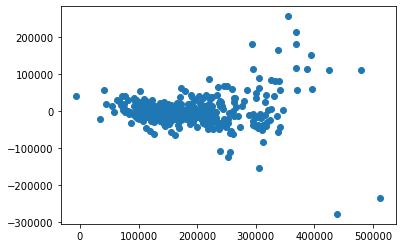

In [63]:
lasso_pred = lasso.predict(X_test_scaled)
lasso_residuals = y_test - lasso_pred
plt.scatter(lasso_pred, lasso_residuals);

Reexamining the box plot and the shape of the histogram of sales price, there might be outliers on the high end of sales price, indicated by the small cluster of outliers in the boxplot, and the small bump in the histogram. In model 2, I will see if removing the 29 outliers improves the model fit.

There are 29 properties above mean + 3sd.
There are 0 properties below mean - 3sd.


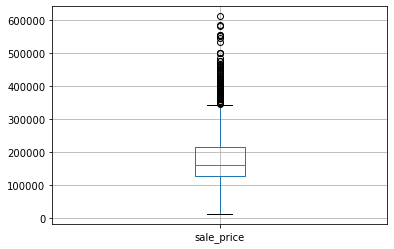

In [40]:
#plotting box plot of sale price
df.boxplot("sale_price");
print("There are", len(df[df["sale_price"]>plus3sd("sale_price")]), "properties above mean + 3sd.")
print("There are", len(df[df["sale_price"]<minus3sd("sale_price")]), "properties below mean - 3sd.")

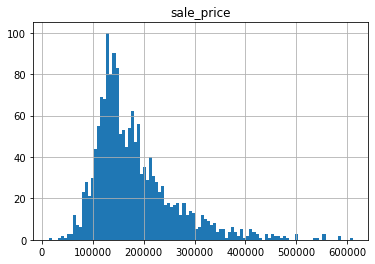

In [41]:
#plotting histogram of sale price
df.hist("sale_price", bins=100);

<a id="Model2"></a>
### Regression Model 2 (Drop outliers)
---
####  Model Preparation
I will be dropping outliers with sale prices exceeding 3SD of the mean to see if I can improve the R2 score of the model.

In [42]:
#dropping outliers from the combined dataset
df.drop(df.index[df["sale_price"]>plus3sd("sale_price")], inplace = True)

#separating test set from train set
traindf = df[df["sale_price"].notnull()]
testdf = df[df["sale_price"].isnull()]

# loading numeric columns excluding sales price
indp_vars2 = [col for col in traindf._get_numeric_data().columns if col not in dv_id]

X2 = traindf[indp_vars2]
y2 = traindf['sale_price']

In [43]:
# train / test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42)

In [44]:
# scaling variables
ss = StandardScaler()
ss.fit(X2_train)
X2_train_scaled = ss.transform(X2_train)
X2_test_scaled = ss.transform(X2_test)

#### Cross-validation
As seen below, the R2 scores are improved from that of model 1. This time, lasso regression performed best, so I will fit the model to the lasso regression.

In [45]:
lr_scores2 = cross_val_score(lr, X2_train, y2_train, cv=10)
ridge_scores2 = cross_val_score(ridge, X2_train_scaled, y2_train, cv=10)
lasso_scores2 = cross_val_score(lasso, X2_train_scaled, y2_train, cv=10)

print("Lin Regression 2:", lr_scores2.mean(), "\t model 1:", lr_scores.mean())
print("Ridge Regression 2:", ridge_scores2.mean(), "\t model 1:", ridge_scores.mean())
print("Lasso Regression 2:", lasso_scores2.mean(), "\t model 1:", lasso_scores.mean())

Lin Regression 2: 0.8307413821060166 	 model 1: 0.8086999201976987
Ridge Regression 2: 0.8309463593444761 	 model 1: 0.8092387827416653
Lasso Regression 2: 0.8314735520210551 	 model 1: 0.8098770414500646


#### Model Fitting and Evaluation

The model had very similar R2 scores for the train and test set, which shows that the model has good predictive capability.

In [46]:
lasso.fit(X2_train_scaled, y2_train)
print("Train set:", lasso.score(X2_train_scaled, y2_train))
print("Test set:", lasso.score(X2_test_scaled, y2_test))
print("CV score:", lasso_scores2.mean())

Train set: 0.8449649062674849
Test set: 0.8474761228361491
CV score: 0.8314735520210551


The top 10 variables affecting sale price remained mostly the same with some reordering. However, one notable change is that the variable "near_pos" fell out of the top 10 and was replaced by "near_rail". The coefficient indicates that houses near railway stations sell for less. The list of top 10 variables are:
1. Overall quality
2. Property age
3. Neighborhood
4. Property size
5. Number of full bathrooms
6. Number of fireplaces
7. Overall condition
8. Number of bedrooms
9. Number of half bathrooms
10. Near a railway station

Notably, the coefficients of a number of variables were reduced to zero in the lasso regression. These variables were:
1. Being located in the South & West of Iowa State University, Greens, College Creek, or Veenker
2. Having an unfinished basement
3. Number of floors
4. Having a fence

In [47]:
lasso_coefs2 = pd.DataFrame({'variable':indp_vars2,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})
lasso_coefs2.sort_values("abs_coef", ascending = False)

,variable,coef,abs_coef
1,overall_qual,26921.858211,26921.858211
3,property_age,-14308.207758,14308.207758
40,area_NridgHt,11980.171126,11980.171126
0,property_size,11680.877226,11680.877226
6,num_full_baths,10364.855466,10364.855466
39,area_NoRidge,7965.332079,7965.332079
9,num_fireplaces,6598.603629,6598.603629
2,overall_cond,5367.275042,5367.275042
27,area_Crawfor,5356.066585,5356.066585
5,num_bedrooms,4511.447914,4511.447914


Compared to model 1, there is much less heteroscedasticity in the residual plot. However, there is still some level of heteroscedasticity, and the residual plot also seems to show a possible non-linear trend as it is U-shaped. This may indicate that the relationship between the variables and sales price is not linear.

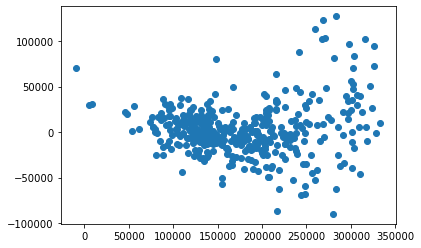

In [48]:
lasso_pred2 = lasso.predict(X2_test_scaled)
lasso_residuals2 = y2_test - lasso_pred2
plt.scatter(lasso_pred2, lasso_residuals2);

<a id="Model3"></a>
### Regression Model 3 (Log-transformation & Drop 0-coeffs)
---
#### Model Preparation
I will be dropping variables that had their coefficients reduced to zero in model 2. Additionally, the residual plot for model 2 may indicate that the relationship between the variables and sale price is not linear. To improve model performance, I will apply a logarithmic transformation to sale price, the dependent variable.

In [49]:
# removing variables with zero coefficients
lasso_zero_coefs = ["area_SWISU", 
                    "area_Greens",
                    "has_unf_bsmt",
                    "area_CollgCr",
                    "num_floors",
                    "has_fence", 
                    "area_Veenker"]

indp_vars3 = [var for var in indp_vars2 if var not in lasso_zero_coefs]

# assigning X and y with logarithmic transformation applied to sale price
X3 = traindf[indp_vars3]
y3 = np.log(traindf['sale_price'])

In [50]:
# train / test split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=42)

In [51]:
# scaling variables
ss = StandardScaler()
ss.fit(X3_train)
X3_train_scaled = ss.transform(X3_train)
X3_test_scaled = ss.transform(X3_test)

#### Cross-validation
The R2 scores showed further improvement from model 2 after zero coefficients were removed and a logarithmic transformation was applied. The models explained approximately 85% of the variance in the data, compared to 81% for model 1, with the ridge regression performing slightly better than the linear and lasso regression.

In [52]:
lr_scores3 = cross_val_score(lr, X3_train, y3_train, cv=10)
ridge_scores3 = cross_val_score(ridge, X3_train_scaled, y3_train, cv=10)
lasso_scores3 = cross_val_score(lasso, X3_train_scaled, y3_train, cv=10)

print("Lin Regression 3:", lr_scores3.mean(), "\t model 2:", lr_scores2.mean(), "\t model 1:", lr_scores.mean())
print("Ridge Regression 3:", ridge_scores3.mean(), "\t model 2:", ridge_scores2.mean(), "\t model 1:", ridge_scores.mean())
print("Lasso Regression 3:", lasso_scores3.mean(), "\t model 2:", lasso_scores2.mean(), "\t model 1:", lasso_scores.mean())

Lin Regression 3: 0.8490940580435827 	 model 2: 0.8307413821060166 	 model 1: 0.8086999201976987
Ridge Regression 3: 0.8492991317084002 	 model 2: 0.8309463593444761 	 model 1: 0.8092387827416653
Lasso Regression 3: 0.8489430935739423 	 model 2: 0.8314735520210551 	 model 1: 0.8098770414500646


#### Model Fitting and Evaluation
The ridge regression penalty successfully improved the predictive ability of the model. The test R2 score was higher than the train R2 score, and the R2 score of 0.88 suggests that the model explains 88% of the variance in the test set.

In [53]:
ridge.fit(X3_train_scaled, y3_train)
print("Train set:", ridge.score(X3_train_scaled, y3_train))
print("Test set:", ridge.score(X3_test_scaled, y3_test))
print("CV score:", ridge_scores3.mean())

Train set: 0.8595105481142871
Test set: 0.8873550776907985
CV score: 0.8492991317084002


The top 10 variables affecting sale price remained mostly the same with some reordering. However, one notable change is that the variable "has_unf_garage" fell out of the top 10 and was replaced by "has_garage". The coefficient indicates that houses that have garages sell for more. The list of top 10 variables are:
1. Overall quality
2. Age of the property
3. Overall condition
4. Size of the property
5. Number of full bathrooms
6. Number of bedrooms
7. Neighborhood
8. Number of fireplaces
9. Has a garage
10. Number of half bathrooms

In [54]:
ridge_coefs3 = pd.DataFrame({'variable':indp_vars3,
                            'coef':ridge.coef_,
                            'abs_coef':np.abs(ridge.coef_)})
ridge_coefs3.sort_values("abs_coef", ascending = False)

,variable,coef,abs_coef
1,overall_qual,0.140900,0.140900
3,property_age,-0.096099,0.096099
2,overall_cond,0.061148,0.061148
0,property_size,0.058422,0.058422
5,num_full_baths,0.058067,0.058067
4,num_bedrooms,0.041536,0.041536
35,area_NridgHt,0.037685,0.037685
8,num_fireplaces,0.036932,0.036932
23,area_Crawfor,0.028888,0.028888
11,has_garage,0.024934,0.024934


The residual plot for the model 3 shows greatly reduced heteroscedasticity and is no longer U-shaped. This indicates a better model fit compared to model 1 and 2.

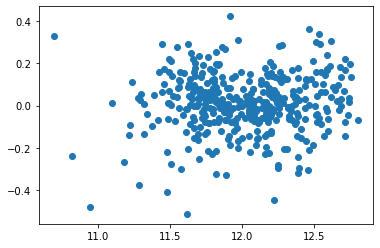

In [55]:
ridge_pred3 = ridge.predict(X3_test_scaled)
ridge_residuals3 = y3_test - ridge_pred3
plt.scatter(ridge_pred3, ridge_residuals3);

## Conclusions & Recommendations
---
The goal of this project was to identify the features that are most important to predict sales price, so as to provide clients with an easy tool that gives a quick estimate of how much their home is worth, and help them identify aspects of their properties they can improve on to increase their selling price. Based on the results of model 3, our recommendations are:

1. **The overall quality of building material and finish is the strongest indicator of selling price:** 
Clients should pay attention to material and finish when purchasing homes to maximize resale value. Clients may also consider refurbishing homes with better material and finishing to increase resale value.

2. **Older houses sell for much less than newer houses:** 
Clients should sell their houses when they are still new, and take care to purchase newer houses to maximize resale value.

3. **Overall condition of the house is a strong indicator of selling price.** 
Clients should take care to maintain the condition of the house to maximize resale value. If the condition of a house has deteriorated over time, the client should attempt to restore the condition of the house as much as possible before selling it.

4. **Larger houses sell for more.** 
Clients should purchase houses that come with larger plots of land. Extending the house if there are large areas of unused land will increase resale value.

5. **The number of bathrooms, bedrooms, and fireplaces are important.** 
Clients should take note of the number of bathrooms and bedrooms when purchasing a house. Building additional bathrooms and bedrooms if there is space can also increase resale value. Building another full bathroom is likely to result in the biggest increase in resale value, followed by building another bedroom, building another fireplace, and then building another half bathroom.

6. **Having a porch or a garage increases resale value, but an unfinished garage decreases resale value.**
Clients should try to buy a home with a porch and/or a garage, finished or unfinished. If the client's home has an unfinished garage, they should finish the garage before selling it to maximize resale value. If the home doesn't have a porch, the client can consider building a porch if there is unused land around the house.

7. **Being near a railway station or major road decreases resale value, but being near a park or greenbelt increases resale value.**
Clients should try to buy homes near greenery that are away from major roads and railway stations. It's possible that being near to major roads and railway stations results in noise pollution, which lowers the value of the property. An alternative explanation is that buyers in Ames City tend to prefer homes that are more secluded.

8. **Having a basement, a pool, or more than one kitchen is not guaranteed to increase resale value. Having more than one kitchen MAY in fact decrease resale value.**
In purchasing a house, clients who seek to maximize resale value should not pay too much attention to whether the house has a basement, pool, or more than one kitchen. If they have already purchased a house with extra kitchens, they may consider converting extra kitchens into bedrooms or bathrooms.

9. **Remodeling a house in itself is not guaranteed to increase resale value.**
If a client is seeking to increase the resale value of their home, they should try to purchase a house that has the previously-mentioned qualities. If they have already bought a home that has a suboptimal resale value, they should remodel strategically according to the previous recommendations.

10. **Location strongly affects the resale value of a house.**
Clients should purchase house in better neighborhoods. The best neighborhoods to own a house are Northridge Heights, Crawford, and Northridge. The worst neighborhoods to own a house are Briardale, Meadow Village, and Edwards.

## Exporting Predictions for Kaggle Submission
---

In [56]:
# removing sales price and variables with zero coefficients from model 2
remove_cols = ["sale_price",
               "Id",
               "area_SWISU", 
               "area_Greens",
               "has_bsmt", 
               "area_CollgCr",
               "num_floors",
               "has_fence", 
               "area_Veenker"]

indp_vars_kaggle = [col for col in testdf._get_numeric_data().columns if col not in remove_cols]
X_kaggle = testdf[indp_vars_kaggle]

In [57]:
# scaling variables
ss = StandardScaler()
ss.fit(X_kaggle)
X_kaggle_scaled = ss.transform(X_kaggle)

In [58]:
#formatting kaggle submission in dataframe
kaggle_predict = np.exp(ridge.predict(X_kaggle_scaled))
kaggle_submission = pd.DataFrame({"Id": testdf["Id"], "SalePrice": kaggle_predict})

In [59]:
#exporting to csv
kaggle_submission.to_csv("../kaggle_submission.csv")